<a href="https://colab.research.google.com/github/24p11/recode-scenario/blob/main/scenario_oncology_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Create fictive clinical notes from Code set (DRG + ICD)

Code set are the raw classification data, we can extract from National database (Base nationale PMSI en France). They are made of 
* classification profile made of grouping variables from DRG records which are prepared with their frequency in the national database
    - age (class)
    - sexe
    - DRG (racine GHM)
    - Main diagnosis (ICD10) : cf
    - Hospitalization management type : cf
* diagnosis associated to each classification profile, extracted with their frequencies
* procedures associated to each classification profile, specialy for surgery and technical gestures, extracted with their frequencies

From thoses raw information we produce a coded clinical scenario which will be uses a seed.

This scenario is transformed into a detail prompt that will be given to a LLM for generation.
From the combinaision of primary and related diagnosis in French discharge abstract, we derived two notions :
* Primary diagnosis : host the notion of principal pathology, it is rather the primary diagnosis of the discharge abstract or the related diagnosis when it exists and that the primary diagnosis of the discharge abstract is from the chapter "Facteurs influant sur l’état de santé" of ICD10
* The Hospitalization management type is rather the term "Primary diagnosis" or the ICD-10 code of the related diagnosis when it exists


In [1]:
#Number of scenarios generate
N_SCENARIO = 1000

#Filters to apply to the initial national data
#Here: patient not cancer ; None if no filters
#QUERY = "icd_primary_code.isin(@gs.icd_codes_cancer)"
QUERY = None

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
import os
import json

from utils import *


The config file is python file (ignore by git) which contains:
- api_key : mistral API Key
- path_results : folder where to write results (scenario and clinical reports)

In [4]:
from config import *

In [18]:
gs = generate_scenario()
# Load official dictionaries
# col_names option allow you to algin your column names the project dictionary.
gs.load_offical_icd("cim_2024.xlsx",col_names={"code" : "icd_code","libelle":"icd_code_description"} )
gs.load_offical_procedures("ccam_actes_2024.xlsx",col_names={"code":"procedure","libelle_long":"procedure_description"} )
col_names={"Code CIM":"icd_parent_code","Localisation":"primary_site","Type Histologique":"histological_type",
           "Stade":"stage","Marqueurs Tumoraux":"biomarkers","Traitement":"treatment_recommandation","Protocole de Chimiothérapie":"chemotherapy_regimen"}
gs.load_cancer_treatement_recommandations("Tableau récapitulatif traitement cancer.xlsx",col_names ) 
col_names={"racine":"drg_parent_code","lib_spe_uma":"specialty","ratio_spe_racine":"ratio"}
gs.load_specialty_refential("dictionnaire_spe_racine.xlsx",col_names)
gs.load_referential_hospital("chu")
gs.load_exclusions("exclusions")

# Load data from BN  PMSI
col_names={"racine":"drg_parent_code","das": "icd_secondary_code","diag":"icd_primary_code","categ_cim":"icd_primary_parent_code",
            "mdp":"case_management_type","nb_situations":"nb","acte":"procedure",
            "mode_entree":"admission_mode",
            "mode_sortie":"discharge_disposition",
            "mode_hospit":"admission_type"}

gs.load_classification_profile("bn_pmsi_cases_20250819.csv", col_names)
gs.load_secondary_icd("bn_pmsi_related_diag_20250818.csv",col_names)
gs.load_procedures("bn_pmsi_procedures_20250818.csv",col_names)

In [19]:
#Prepare cases
df_profile = gs.df_classification_profile

array([[<AxesSubplot:title={'center':'nb'}>]], dtype=object)

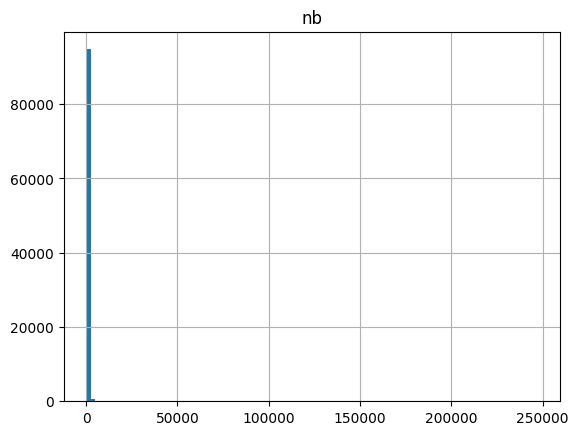

In [20]:
df_profile.hist(column="nb",bins=100)

In [21]:
n_tot_r = np.sum(df_profile.nb)
df_profile = df_profile.assign(effectif = df_profile.nb,
                    effectif_trans = np.sqrt(df_profile.nb)*1000000000/n_tot_r)
df_profile = df_profile.assign(effectif_final = np.where(df_profile.effectif_trans>1500,1500,df_profile.effectif_trans))


array([[<AxesSubplot:title={'center':'effectif_final'}>]], dtype=object)

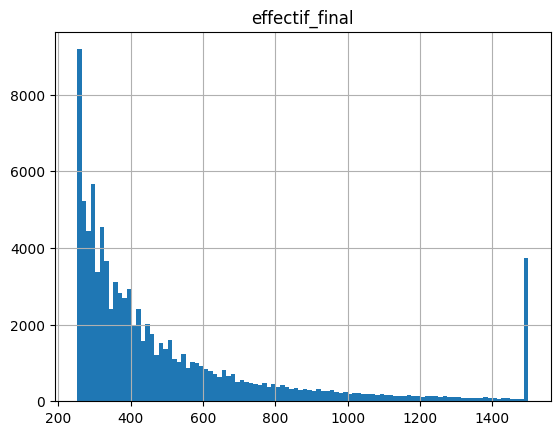

In [22]:
df_profile.hist(column="effectif_final",bins=100)

# Sampling

In [23]:
#Exclude some rows regarding QUERY
if QUERY is not None : 
    df_profile_sample = df_profile.query(QUERY)
else :
    df_profile_sample = df_profile.copy()

df_profile_sample = df_profile_sample.sample(N_SCENARIO, weights="effectif_final").reset_index(drop=True)
df_profile_sample.drop(columns=["nb","effectif","effectif_trans","effectif_final"],inplace=True)

In [14]:
list_scenario = []

for i in tqdm(range(len(df_profile_sample))):
# for i in tqdm(range(1)):
    profile = df_profile_sample.iloc[i].copy()
    scenario = gs.generate_scenario_from_profile(profile)
    row = {k:scenario[k] for k in scenario.keys()}
    user_prompt = gs.make_prompts_marks_from_scenario(scenario)
    system_prompt = gs.create_system_prompt(scenario)
    row["user_prompt"] = user_prompt
    row["system_prompt"] = system_prompt
    
    if  scenario["icd_primary_code"]  in gs.icd_codes_cancer  :
        prefix = """Le compte rendu suivant respecte les élements suivants :
        - les diagnostics ont une formulation moins formelle que la définition du code
        - le type histologique et la valeur des biomarqueurs si recherchés
        - le plan du CRH est conforme aux recommandations.
        """
    else :
        prefix = """Le compte rendu suivant respecte les élements suivants :
        - les diagnostics ont une formulation moins formelle que la définition du code
        - le plan du CRH est conforme aux recommandations.
        """
    
    row["prefix"] = prefix
    row["prefix_len"] = len(prefix)
    list_scenario.append(row)

  4%|▎         | 723/20000 [39:37<17:36:41,  3.29s/it]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
keep_cols = ['age',  'cage', 'cage2','sexe', 'date_entry', 'date_discharge', 'date_of_birth',
       'first_name', 'last_name', 'icd_primary_code', 'icd_primary_description', 'icd_parent_code',
       'case_management_type','case_management_type_description', 'coding_rule','case_management_type_text', 
       'drg_parent_code', 'drg_parent_description',
       'icd_secondaray_code',  'text_secondary_icd_official', 
        'procedure', 'text_procedure',
        'admission_type','admission_mode', 'discharge_disposition', 'dms', 'los_mean', 'los_sd',
       'cancer_stage', 'score_TNM', 'histological_type',
       'treatment_recommandation', 'chemotherapy_regimen', 'biomarkers',
       'first_name_med', 'last_name_med',
       'department','hospital','template_name','user_prompt', 'system_prompt', 'prefix', 'prefix_len']
df_scenario = pd.DataFrame(list_scenario)[keep_cols]
df_scenario.to_csv("results/generated_scenarios_"+dt.datetime.now().strftime('%Y%m%d_%H%M')+".csv")

## Generation with Mitral API

In [15]:
from config import *
api_url = "https://api.mistral.ai/v1/chat"
model = "mistral-large-latest"
client = Mistral(api_key=api_key)

In [27]:
scenario_file_name = "generated_scenarios_20250922_1207"
n_samples_by_batch = 12

In [9]:
df_scenarios= pd.read_csv(path_results + scenario_file_name + ".csv",index_col=0)

In [16]:
for i in range(0, int(len(df_scenarios)/n_samples_by_batch)):
  print(str(i*n_samples_by_batch) + " - "+ str((i+1)*n_samples_by_batch) )
  prompts = df_scenarios[i*n_samples_by_batch:(i+1)*n_samples_by_batch].reset_index(drop=True)
  input_file = create_input_file(client, prompts)
  print(f"Created input file {input_file}")
  batch_job = run_batch_job(client, input_file, model)
  print(f"Job duration: {batch_job.completed_at - batch_job.created_at} seconds")
  download_file(client, batch_job.output_file, path_results +"tmp/batch_" +  str(i) + ".json" )
  prompts.to_csv(path_results+"tmp/batch_" +  str(i) + ".csv" )

0 - 12
Created input file id='546e2247-ba95-4949-9291-04caed0cfa90' object='file' bytes=104998 created_at=1758621088 filename='file.jsonl' purpose='batch' sample_type='batch_request' source='upload' num_lines=12
Batch job 430c2ede-9142-4e76-aa31-8a2fb74da36f completed with status: SUCCESS
Job duration: 208 seconds
Downloaded file to P:/Commun/Sources_donnees_complementaires/generation/recode_scenario/tmp/batch_0.json


In [29]:

df_res_final=pd.DataFrame()

p = re.compile("```")

output_dir = path_results+"tmp"

for i in range(int(len(df_scenarios)/n_samples_by_batch) ): # Iterate through all batch files
    file_path = os.path.join(output_dir, f"batch_{i}.json")
    if os.path.exists(file_path):
        results = []
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                results.append(json.loads(line.strip()))

        # Assuming extract_response is defined and works correctly
        # and results contains the data structure as seen in the previous outputs

        prep_dict=[]
        for result_item in results:
            # Check if the item has a response and extract it
            if "response" in result_item and result_item["response"] and "body" in result_item["response"] and "choices" in result_item["response"]["body"]:
                message_content=result_item["response"]["body"]["choices"][0]["message"]["content"]
                if len(message_content)<40:
                  continue
                m = p.finditer(message_content)
                positions = [i.span() for i in m]
                if len(positions) == 1:
                  res = message_content[positions[0][1]+4:]
                else:
                  res = message_content[positions[0][1]+4:positions[1][0]]

                prep_dict.append({"bacth":i,"num_in_":result_item['custom_id'],"crh":res})

        df_scenarios_save = pd.read_csv(output_dir+"/batch_" +  str(i) + ".csv",index_col=0)
        df_res_tmp = pd.DataFrame(prep_dict)
        df_res_tmp["num_in_"]=  df_res_tmp["num_in_"].astype(int)
        df_res_tmp = df_scenarios_save.merge(df_res_tmp,right_on="num_in_",left_index=True)
        df_res_final = pd.concat([df_res_final,df_res_tmp])

In [34]:
df_res_final.to_csv(path_results+ "clinical_report_from_"+scenario_file_name+".csv")

In [35]:
path_results+ "clinical_report_from_"+scenario_file_name+".csv"

'P:/Commun/Sources_donnees_complementaires/generation/recode_scenario/clinical_report_from_generated_scenarios_20250922_1207.csv'